# Overview and main features

**1. Import packages**

**2. Load and explore data:**
* Load and split data into train and validation sets with a stratified (*STRAT == True*) or simple K-Fold splitter. As reference for the optional stratification either a calculated multilabel (based on selected features and/or labels) or simply the label can be used (*EXTENDED_STRAT == False*).
* External dataset can be merged with the train dataset (*ADD_EXTERN_DATA == True*).
* Calculate statistical features (mean and count).
* List of dataset columns including data types and number of non-zero elements.
* Show number of unique elements of categorical features.
* Show probability distribution of numerical features.
* Compare probabilty distribution of numerical features between train, validation and test sets.

**3. Preprocess data:**
* The dataset includes 2 main types of data: numerical features and categorical features.
* Preprocessing pipelines include an imputing step (for robustness of pipeline, currently there are no missing values in raw data), a transforming step and a scaling step (if necessary).
* Selected preprocessing pipelines will be merged with a ColumnTransformer, possible pipelines are:
    * MinMax/standard/robust scaling of numerical features
    * Principal component analysis (PCA) of numerical features
    * Logaritmic/square/cube/square root/cube root transformation of numerical features
    * KBins discretization of numerical features
    * Ordinal/onehot encoding of categorical features
    * Statistical features (frequency of feature values / mean and count of target values for feature values) for both numerical and categorical features
* Optionally, model based meta-features can be added (*META_FEAT == True*)
* Optionally, preprocessed features will be passed into a feature selection model to extract most relevant features. The maximum number of features can be configured (*MAX_FEAT*).

**4. Define model space for ML methods:**
* Definition of model space with a large number of possible ML methods:
    * Linear models: SGD
    * Support vector machine model: SVC
    * Ensemble models: RandomForest / GradientBoosting / AdaBoost / HistGradientBoosting / XGB / LGBM / CatBoost
    * Other models: KNeighbors
* Optionally, GPU acceleration can be activated (if supported by choosen ML method(s)) by *GPU_ACC*.

**5. Training and evaluation:**
* Definition of model parameter sets and tuner interfaces.
* Simple fitting or tuning (*TUNING == True*) of choosen models (*EST_IDS*) on train dataset with K-Fold method (*FOLD == k*).
* Early stopping and the usage of category data type can be configured (*EST_IDS_W_EARLYSTOPPING/EST_IDS_W_CAT_FEAT*).

**6. Evaluation:**
* Calculate ROC_AUC scores for all estimators on both train and validation dataset.
* ROC_AUC score on mean value of ensemble predictions for each fold on validation dataset.
* Show feature importances.
* Show ROC_AUC scores of subcategory subsets.
* Show worse ROC_AUC scores of multicategory subsets

**7. Submission:**
* Predict labels and create submission.csv file.
* If more than 1 model have been choosen in EST_IDS (Ensemble solution) then the prediction will be an average of the predictions of the single models.

# 1. Import packages

In [1]:
## Import packages

# General purpose modules
import time
from copy import deepcopy
import warnings

# Data handling and visualization modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp

# Skikit-learn preprocessing and evaluation modules
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import roc_auc_score

# Skikit-learn ML modules
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# Further ML modules
import xgboost as xgboost
import lightgbm as lightgbm
from catboost import CatBoostClassifier

# 2. Load and explore data

In [2]:
## Read csv files and spliting the data into training and validation set

ADD_EXTERN_DATA = False # Extend dataset with external data
STRAT = False # Use stratification for data spliting
EXTENDED_STRAT = False # Stratification is based on multiple features

# Read csv files
trainval = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
extern_data = pd.read_csv('/kaggle/input/heartdisease/Heart_Disease_Prediction.csv')
if ADD_EXTERN_DATA:
    trainval = pd.concat([trainval[trainval.columns[1:]], extern_data[trainval.columns[1:]]]
                         ).reset_index(drop=True).reset_index().rename(columns={'index':'id'})

# Discretization of labels and numeric features
target = 'Heart Disease'
trainval[target] = LabelEncoder().fit_transform(trainval[target]).astype(np.uint8)

# Calculate statistical features for all columns
global_stats = {'mean': trainval[target].mean(), 'median': trainval[target].median(), 'count': 0}
freq_encodings = {}
stats_mean = {}
stats_median = {}
stats_count = {}
for c in trainval.columns[1:-1]:
    freq_encodings[c] = trainval[c].value_counts(normalize=True).to_dict()
    for stat in ['mean', 'median', 'count']:
        globals()['stats_' + stat][c] = trainval.groupby(c)[target].agg([stat]).to_dict()[stat]

# Determine stratification bins
strat_encoder = LabelEncoder()
strat_encoder_eval = LabelEncoder()
strat_cols = ['Thallium', 'Chest pain type', target]
strat_cols_eval = ['Thallium', 'Chest pain type', 'Number of vessels fluro']
trainval['multicat'] = strat_encoder.fit_transform(trainval[strat_cols].astype(str).agg('_'.join, axis=1))
trainval['multicat_eval'] = strat_encoder_eval.fit_transform(trainval[strat_cols_eval].astype(str).agg('_'.join, axis=1))
sss = (StratifiedShuffleSplit if STRAT else ShuffleSplit)(n_splits=1, test_size=0.01, random_state=42)

# Spliting data
train_idx, val_idx = next(sss.split(trainval, trainval['multicat'] if EXTENDED_STRAT else trainval[target]))
train = trainval.iloc[train_idx].reset_index()
val = trainval.iloc[val_idx].reset_index()
trainval_labels = trainval.pop(target)
train_labels = train.pop(target)
val_labels = val.pop(target)

# Verify sizes
print(f"Total rows:   {len(trainval)}")
print(f"Dev train:    {len(train)} ({len(train)/len(trainval):.2%})")
print(f"Dev valid:    {len(val)} ({len(val)/len(trainval):.2%})")
print(f"Number of unique elements in multicat column: {len(trainval['multicat'].unique())}")
print('-'*80, end='\n\n')

# Size of stratification bins
print(trainval['multicat'].value_counts().tail())
print('-'*80, end='\n\n')
print(trainval['multicat_eval'].value_counts().tail())

Total rows:   630000
Dev train:    623700 (99.00%)
Dev valid:    6300 (1.00%)
Number of unique elements in multicat column: 24
--------------------------------------------------------------------------------

multicat
1     930
10    547
11    327
8     222
9      65
Name: count, dtype: int64
--------------------------------------------------------------------------------

multicat_eval
22    59
17    36
23    25
18    15
19     5
Name: count, dtype: int64


List of dataset columns including data types and number of non-zero elements: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623700 entries, 0 to 623699
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    623700 non-null  int64  
 1   id                       623700 non-null  int64  
 2   Age                      623700 non-null  int64  
 3   Sex                      623700 non-null  int64  
 4   Chest pain type          623700 non-null  int64  
 5   BP                       623700 non-null  int64  
 6   Cholesterol              623700 non-null  int64  
 7   FBS over 120             623700 non-null  int64  
 8   EKG results              623700 non-null  int64  
 9   Max HR                   623700 non-null  int64  
 10  Exercise angina          623700 non-null  int64  
 11  ST depression            623700 non-null  float64
 12  Slope of ST              623700 no

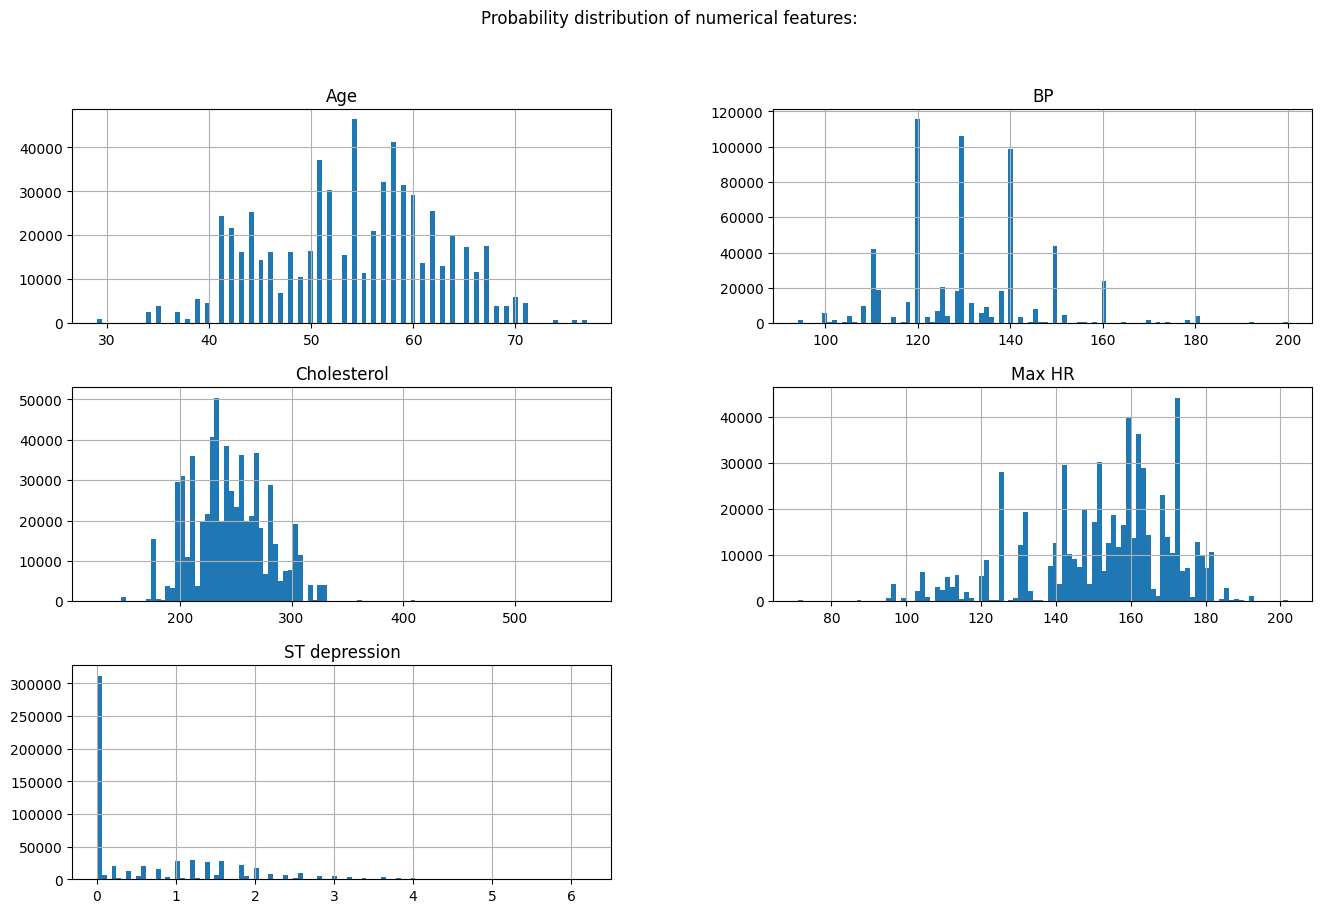

In [3]:
## Explore train dataset

print('List of dataset columns including data types and number of non-zero elements: ', end='\n\n')
train.info()
print('-'*80, end='\n\n')

# Explore categorical features
cat_columns = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST',
              'Number of vessels fluro', 'Thallium']
print('Number of unique elements of categorical features: ', end='\n\n')
for cat in cat_columns:
    print(train[cat].value_counts(), end='\n\n')

# Explore numerical features
num_columns = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
train[num_columns].hist(bins=100, figsize=(16,10))
plt.suptitle('Probability distribution of numerical features: ')
print('-'*80, end='\n\n')

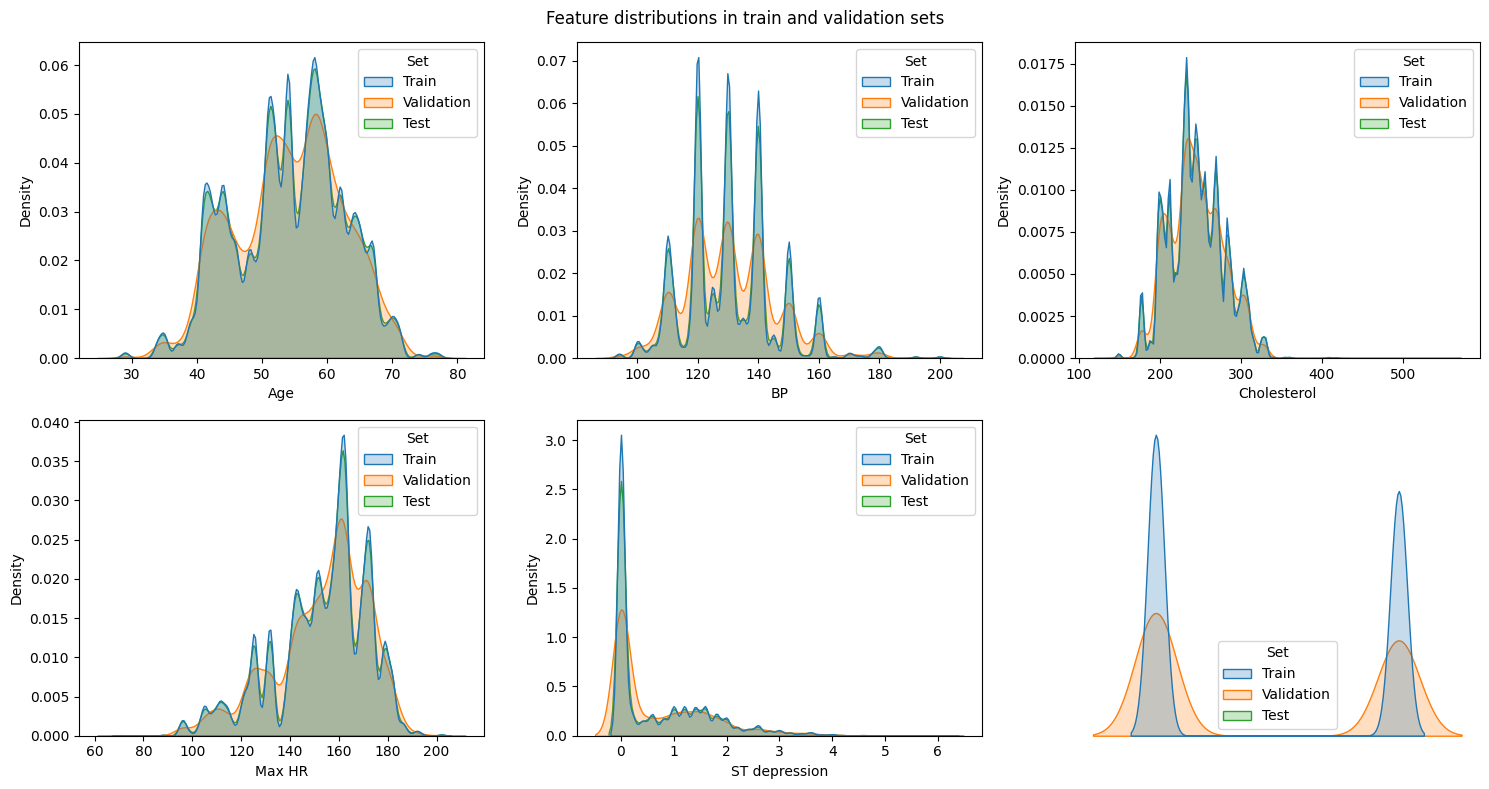

In [4]:
## Compare probabilty distribution of numerical features between train, validation and test sets

df_plot = pd.concat([train[num_columns].assign(Set='Train'), val[num_columns].assign(Set='Validation'),
                     test[num_columns].assign(Set='Test')])
df_plot.insert(5, value=pd.concat([train_labels, val_labels, pd.Series([None] * len(test), name=target)]), column=target)
df_plot.reset_index(drop=True, inplace=True)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn") # Suppress the specific FutureWarning

n_cols = 3
n_rows = (len(num_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
fig.suptitle('Feature distributions in train and validation sets')
axes = axes.flatten()
for i in range(len(num_columns), len(axes)):
    axes[i].axis('off')
for i, col in enumerate(df_plot.columns[:-1]):
    sns.kdeplot(data=df_plot, x=col, ax=axes[i], hue='Set', common_norm=False, fill=True)
plt.tight_layout()
plt.show()
del df_plot

# 3. Preprocess data

In [5]:
## Helping functions for adding statistical features

def frq_enc(X, features, freq_encodings=freq_encodings):
    X_freq = pd.DataFrame()
    for c in features:
        X_freq[c] = X[c].map(freq_encodings[c]).astype(float).fillna(0)
    return X_freq

def target_stats(X, features, st_type, global_stats=global_stats):
    stats = globals()['stats_' + st_type]
    X_stat = pd.DataFrame()
    for c in features:
        X_stat[c] = X[c].map(stats[c]).fillna(global_stats[st_type])
    return X_stat

In [6]:
## Define and fit preprocessing pipeline

robust_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                            ('robust_scaling', RobustScaler())])
ordinal_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                             ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int8))])
onehot_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                            ('onehot', OneHotEncoder(sparse_output=False))])
log_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('log_trans', FunctionTransformer(func=lambda x: np.log(x+0.001), feature_names_out='one-to-one')),
                         ('robust_scaling', RobustScaler())])
square_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                            ('square_trans', FunctionTransformer(func=np.square, feature_names_out='one-to-one')),
                            ('robust_scaling', RobustScaler())])
cube_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                          ('cube_trans', FunctionTransformer(func=lambda x: np.power(x, 3), feature_names_out='one-to-one')),
                          ('robust_scaling', RobustScaler())])
sqrt_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                          ('sqrt_trans', FunctionTransformer(func=np.sqrt, feature_names_out='one-to-one')),
                          ('robust_scaling', RobustScaler())])
cbrt_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                          ('cbrt_trans', FunctionTransformer(func=np.cbrt, feature_names_out='one-to-one')),
                          ('robust_scaling', RobustScaler())])
kbins_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                           ('kbins', KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal', random_state=42)),
                           ('kbins_cast', FunctionTransformer(lambda X: X.astype(np.uint8), feature_names_out='one-to-one'))])
frq_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('frq', FunctionTransformer(func=lambda x: frq_enc(x, x.columns), feature_names_out='one-to-one'))])
mean_pipeline = Pipeline([('mean', FunctionTransformer(func=lambda x: target_stats(x, x.columns, 'mean'), feature_names_out='one-to-one'))])
median_pipeline = Pipeline([('median', FunctionTransformer(func=lambda x: target_stats(x, x.columns, 'median'), feature_names_out='one-to-one'))])
count_pipeline = Pipeline([('count', FunctionTransformer(func=lambda x: target_stats(x, x.columns, 'count'), feature_names_out='one-to-one'))])

# Preprocessing pipeline
nonlinear_transformer = ColumnTransformer([("scaled", robust_pipeline, num_columns),
                                           ("log", log_pipeline, num_columns),
                                           ("square", square_pipeline, num_columns),
                                           ("cube", cube_pipeline, num_columns),
                                           ("sqrt", log_pipeline, num_columns),
                                           ("cbrt", square_pipeline, num_columns)])
pca_pipeline = Pipeline([('nonlinear', nonlinear_transformer), ('pca', PCA(random_state=42))])

preprocessing = ColumnTransformer([("scaled", robust_pipeline, num_columns),
                                   #("pca", pca_pipeline, num_columns),
                                   ("cluster", kbins_pipeline, num_columns),
                                   ("frqn", frq_pipeline, num_columns),
                                   ("ordinal", ordinal_pipeline, cat_columns),
                                   ("frqc", frq_pipeline, cat_columns),
                                   ("mean", mean_pipeline, num_columns+cat_columns),
                                   ("median", median_pipeline, num_columns+cat_columns),
                                   ("count", count_pipeline, num_columns+cat_columns)]).set_output(transform='pandas')

# Preprocess data
train_prepared = preprocessing.fit_transform(train)
val_prepared = preprocessing.transform(val)
print(f'Number of unfiltered features: {train_prepared.shape[1]}')

Number of unfiltered features: 70


In [7]:
## Calculate model based meta-features with linear models

META_FEAT = False # Add model based meta features
META_PCA = False # Use PCA for calculating model based meta features

if META_FEAT:
    preprocessing_meta = ColumnTransformer([("pca", pca_pipeline, num_columns) if META_PCA else ('nonlinear', nonlinear_transformer, num_columns),
                                            ("onehot", onehot_pipeline, cat_columns)]).set_output(transform='pandas')
    train_meta = preprocessing_meta.fit_transform(train)
    val_meta = preprocessing_meta.transform(val)
    print(f'Number of unfiltered features for meta feature learning: {train_meta.shape[1]}')
    
    lr_meta = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(train_meta, train_labels)
    sgdc_meta = SGDClassifier(loss='log_loss', class_weight='balanced', random_state=42).fit(train_meta, train_labels)
    
    train_prepared['lr_meta'] = lr_meta.predict_proba(train_meta)[:,1]
    val_prepared['lr_meta'] = lr_meta.predict_proba(val_meta)[:,1]
    train_prepared['sgdc_meta'] = sgdc_meta.predict_proba(train_meta)[:,1]
    val_prepared['sgdc_meta'] = sgdc_meta.predict_proba(val_meta)[:,1]
    print(f'Number of unfiltered features including meta features: {train_prepared.shape[1]}')

In [8]:
## Final feature selection based on XGBoost feature importances

MAX_FEAT = None # Max number of features after feature selection

if MAX_FEAT:
    xgbr_fs = xgboost.XGBClassifier(device='cpu', random_state=42).fit(train_prepared, train_labels)
    model_fs = SelectFromModel(xgbr_fs, max_features=MAX_FEAT, threshold=1e-5, prefit=True).fit(train_prepared, train_labels)
    train_prepared = pd.DataFrame(model_fs.transform(train_prepared), columns=model_fs.get_feature_names_out())
    val_prepared = pd.DataFrame(model_fs.transform(val_prepared), columns=model_fs.get_feature_names_out())
print(f'Number of selected features: {train_prepared.shape[1]}')

Number of selected features: 70


# 4. Define model space for ML methods

In [9]:
## Helping function to create parameter grids

def make_param(param_dict, model='est'):
    for elem in param_dict.copy():
        if elem == 'n_components':
            param_dict['pca'+'__'+elem] = param_dict.pop(elem)
        else:
            param_dict[model+'__'+elem] = param_dict.pop(elem)
    return param_dict

In [10]:
## Machine learning models and their hyperparameter search space

GPU_ACC = True

# Models
svc = SVC(kernel='linear', class_weight='balanced')
rfc = RandomForestClassifier(random_state=42)
kneigh = KNeighborsClassifier()
gbc = GradientBoostingClassifier(random_state=42)
xgb = xgboost.XGBClassifier(objective='binary:logistic', enable_categorical=True, device='cuda' if GPU_ACC else 'cpu',
                            random_state=42, eval_metric="auc")
ada = AdaBoostClassifier(random_state=42)
hgbc = HistGradientBoostingClassifier(scoring='roc_auc', class_weight='balanced', random_state=42)
lgbm = lightgbm.LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, random_state=42,
                               device ='gpu' if GPU_ACC else 'cpu', verbosity=-1)
catc = CatBoostClassifier(eval_metric='AUC', auto_class_weights='Balanced', random_state=123,
                          task_type='GPU' if GPU_ACC else 'CPU', verbose=False)
sgdc = SGDClassifier(loss='log_loss', class_weight='balanced', random_state=42)

# Model space
EstimatorStr = {1: 'svc', 2: 'rfc', 3: 'kneigh', 4: 'gbc', 5: 'xgb', 6: 'ada', 7: 'hgbc', 8: 'lgbm', 9: 'catc', 10: 'sgdc'}
EstimatorMdl = {1: svc, 2: rfc, 3: kneigh, 4: gbc, 5: xgb, 6: ada, 7: hgbc, 8: lgbm, 9: catc, 10: sgdc}

In [11]:
## Tuned hyperparameter sets

# svc parameter
param_single_svc = make_param({}) #
# rfc parameter
param_single_rfc = make_param({}) # 
# kneight parameter
param_single_kneigh = make_param({}) # 
# gbc parameter
param_single_gbc = make_param({}) # 
# xgb parameter
param_single_xgb = make_param({'n_estimators': 8000, 'learning_rate': 0.03, 'early_stopping_rounds': 100,
                               }) # 
# ada parameter
param_single_ada = make_param({}) # 
# hgbc parameter
param_single_hgbc = make_param({'max_iter': 8000, 'learning_rate': 0.03, #'max_bins': 160,
                                }) # 
# lgbm parameter
param_single_lgbm = make_param({'n_estimators': 8000, 'learning_rate': 0.03, 'early_stopping_rounds': 100,
                                }) # 
# catc parameter
param_single_catc = make_param({'n_estimators': 8000, 'learning_rate': 0.03,
                                'early_stopping_rounds': 400, 'max_depth': 5,
                                #'l2_leaf_reg': 0,
                                }) # 
# sgdc parameter
param_single_sgdc = make_param({}) # 

In [12]:
## Hyperparameter sets for parameter tuning

# xgb parameter
param_grid_xgb = make_param({#'n_estimators': [140, 500, 1000, 1500],
                             'max_depth': [2, 4, 6, 8],
                             'learning_rate': [0.1, 0.3, 0.5, 0.7],
                             'subsample': [0.1, 0.5, 0.9],
                             'colsample_bytree': [0.1, 0.5, 0.9],
                             'reg_lambda': [0, 0.1, 1, 10],
                             'reg_alpha': [0, 0.1, 1, 10],
                             })
# hgbc parameter
param_grid_hgbc = make_param({#'max_depth': [3, 4, 5, 6, 9, 12],
                              #'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                             'max_bins': [10,20,40,80,160,255]
                              })
# lgbm parameter
param_grid_lgbm = make_param({'num_leaves': [80,110,120,125,130,135,140,150,180],
                              'max_depth': [24,29,31,32,33,35,40],
                              'learning_rate': [0.05,0.1,0.2],
                              #'n_estimators': [100,200,300],
                              })
# catc parameter
param_grid_catc = make_param({'n_estimators': [8000], # 4000, 6000, 8000, 10000
                              'learning_rate': [0.03], # 0.005, 0.01, 0.03, 0.05, 0.1
                              'max_depth': [4,5,6,7,8], #
                              'early_stopping_rounds': [100],
                                #'learning_rate': 0.06, 'max_depth': 2, 'l2_leaf_reg': 0.3
                                })

# 5. Training

In [ ]:
## Single fitting with tuned parameters or grid search for machine learning methods

TUNING = False # Choose between single fitting or parameter tuning
FOLDS = 14
EST_IDS = [9] # Choose model(s) to tune {1: 'svr', 2: 'rfr', 3: 'kneigh', 4: 'gbr', 5: 'xgb', 6: 'ada', 7: 'hgbr', 8: 'lgbm', 9: 'catr', 10: 'sgdr'}
EST_IDS_W_EARLYSTOPPING = [5,8,9]
EST_IDS_W_CAT_FEAT = [5,7,8,9]

for est_id in EST_IDS:
    start_time = time.time()
    # Define pipeline
    pipeline = Pipeline([('est', EstimatorMdl[est_id])])

    # Cross-validation configuration w/wo extended stratification
    skf = (StratifiedKFold if STRAT else KFold)(n_splits=FOLDS, shuffle=True, random_state=42)
    cv_gen = skf.split(train_prepared, train['multicat'] if EXTENDED_STRAT else train_labels)

    # Cast categorical features to 'category' for choosen estimators being able to handle it
    ordinal_columns = make_column_selector(pattern='ordinal|cluster')(train_prepared)
    train_prepared[ordinal_columns] = train_prepared[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
    val_prepared[ordinal_columns] = val_prepared[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
    catc.set_params(cat_features=ordinal_columns if est_id in EST_IDS_W_CAT_FEAT else None)
    
    # Fitting or tuning on train dataset with k-fold cross-validation
    param = globals()[f'param_grid_{EstimatorStr[est_id]}' if TUNING else f'param_single_{EstimatorStr[est_id]}']
    if TUNING:
        grid = GridSearchCV(pipeline, param, scoring='roc_auc', verbose=1, cv=cv_gen)
        #grid.fit(cp.array(train_prepared), np.array(train_labels))
        grid.fit(train_prepared, np.array(train_labels))
        print(grid.best_params_)
        print(grid.cv_results_)
        globals()[f'model1_{EstimatorStr[est_id]}'] = grid.best_estimator_
    else:
        for i, (train_index, eval_index) in enumerate(cv_gen):
            X_train, X_eval = train_prepared.iloc[train_index], train_prepared.iloc[eval_index]
            y_train, y_eval = train_labels.iloc[train_index], train_labels.iloc[eval_index]
            pipeline_train = deepcopy(pipeline)
            pipeline_train.set_params(**param) # , est__random_state=(i+1)*1
            eval_set = {}
            if est_id in EST_IDS_W_EARLYSTOPPING:
                eval_set['est__eval_set'] = [(X_eval, np.array(y_eval))]
                if est_id==5: eval_set['est__verbose'] = 0

            #pipeline_train.fit(cp.array(X_train), np.array(y_train), **eval_set)
            pipeline_train.fit(X_train, np.array(y_train), **eval_set)
            
            globals()[f'model{i+1}_{EstimatorStr[est_id]}'] = pipeline_train
            print(f'Estimator: {EstimatorStr[est_id]} of fold {i+1} is fitted')
            print(f'Elapsed time: {int(time.time() - start_time)} [s]')
            print('-'*40)

Default metric period is 5 because AUC is/are not implemented for GPU


# 6. Evaluation

In [ ]:
## Calculate ROC_AUC scores for each estimators and mean ROC_AUC score over all estimators and folds

val_pred = pd.DataFrame()

# ROC_AUC scores for each estimator and fold
for est_id in EST_IDS:
    # Cast categorical features to 'category' for choosen estimators being able to handle it
    train_prepared[ordinal_columns] = train_prepared[ordinal_columns].astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'int8')
    val_prepared[ordinal_columns] = val_prepared[ordinal_columns].astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'int8')
    
    for i in range(1 if TUNING else FOLDS):
        # Select proper model
        pipeline_val = globals()[f'model{i+1}_{EstimatorStr[est_id]}']
        
        # Calculate and show scores
        train_score = roc_auc_score(np.array(train_labels), pipeline_val.predict_proba(train_prepared)[:,1])
        val_score = roc_auc_score(np.array(val_labels), pipeline_val.predict_proba(val_prepared)[:,1])
        print(f'Estimator: {EstimatorStr[est_id]} of fold {i+1}')
        print(f'Train ROC_AUC  score: {train_score}')
        print(f'Val ROC_AUC  score: {val_score}')
        print(f'Elapsed time: {int(time.time() - start_time)} [s]')
        print('-'*40)
        
        # Store predictions
        val_pred[f'pred_{EstimatorStr[est_id]}_{i+1}'] = pipeline_val.predict_proba(val_prepared)[:,1]

# ROC_AUC score on mean value of ensemble predictions for each fold
val_pred['pred_score'] = val_pred.mean(axis=1)
val_pred[target] = val_labels
val_score_avg = roc_auc_score(val_labels, val_pred['pred_score'])
print(f'Mean val ROC_AUC score over all estimators and folds: {val_score_avg}')
print('-'*40)
print('Show predictions and labels of validation dataset: ')
print(val_pred)

In [ ]:
## Show ROC_AUC scores of subcategory subsets

subcats = []
subcat_ROC_AUC_scores  = []
for cat in cat_columns:
    for subcat in np.sort(val[cat].unique()):
        subcats.append(cat+'_'+str(subcat))
        val_filtered = val_pred[target][val[cat] == subcat]
        val_labels_filtered = val_pred['pred_score'][val[cat] == subcat]
        subcat_ROC_AUC_scores.append(roc_auc_score(val_filtered, val_labels_filtered))

# Create bar chart
fig1, ax1 = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap('viridis')
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
normalized_values = rescale(subcat_ROC_AUC_scores)
ax1.barh(subcats, np.array(subcat_ROC_AUC_scores)-val_score_avg, color=cmap(normalized_values), left=val_score_avg)
plt.title(f'ROC_AUC scores of subcategory subsets compared to the average ROC_AUC score')
plt.xlabel('ROC_AUC score')
plt.ylabel('Subcategories')
ax1.axvline(x=val_score_avg, color='green', linestyle='-.')
plt.tight_layout()
ax1.tick_params(left=False, bottom=True)

In [ ]:
## Show feature importances

if est_id in [5, 8, 9]:
    # Sort feature names and their importances
    categories = train_prepared.columns
    values = globals()[f'model1_{EstimatorStr[est_id]}'][-1].feature_importances_+1e-4
    sorted_values, sorted_categories = zip(*sorted(zip(values,categories), reverse=False))
    
    # Plot feature importances
    fig3, ax3 = plt.subplots(figsize=(10, 10))
    normalized_values = rescale(np.log(sorted_values))
    ax3.barh(sorted_categories, sorted_values, color=cmap(normalized_values), log=True)
    plt.title(f'Feature Importances (Magnitude)')
    plt.xlabel('Logarithmic importance score')
    plt.ylabel('Features')
    plt.tight_layout()
    ax3.tick_params(left=False, bottom=True)

In [ ]:
## Show worse ROC_AUC scores of multicategory subsets

multicats = []
multicat_ROC_AUC_scores = []
for multicat in trainval['multicat_eval'].unique():
    if len(val_labels[val['multicat_eval'] == multicat].unique()) > 1:
        multicats.append(multicat)
        val_filtered = val_pred[target][val['multicat_eval'] == multicat]
        val_labels_filtered = val_pred['pred_score'][val['multicat_eval'] == multicat]
        multicat_ROC_AUC_scores.append(roc_auc_score(val_filtered, val_labels_filtered))
multicats = strat_encoder_eval.inverse_transform(multicats)
sorted_multicat_ROC_AUC_scores, sorted_multicats = zip(*sorted(zip(multicat_ROC_AUC_scores,multicats), reverse=False))

# Create bar chart
fig2, ax2 = plt.subplots(figsize=(10, 8))
n_top = 10
cmap = plt.get_cmap('viridis')
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
normalized_values = rescale(sorted_multicat_ROC_AUC_scores[:n_top])
ax2.barh(sorted_multicats[:n_top], np.array(sorted_multicat_ROC_AUC_scores[:n_top])-val_score_avg, color=cmap(normalized_values), left=val_score_avg)
plt.title(f'Worse {n_top} ROC_AUC scores of multicategory subsets')
plt.xlabel('ROC_AUC score')
plt.ylabel('Subcategories (Thallium_Chest pain type_Number of vessels fluro)')
plt.tight_layout()
ax2.tick_params(left=False, bottom=True)

# 7. Submission

In [ ]:
## Test prediction & submission 

test_prepared = preprocessing.transform(test)
if MAX_FEAT:
    test_prepared = pd.DataFrame(model_fs.transform(test_prepared), columns=model_fs.get_feature_names_out())
if META_FEAT:
    test_meta = preprocessing_meta.transform(test)
    test_prepared['lr_meta'] = lr_meta.predict_proba(test_meta)[:,1]
    test_prepared['sgdc_meta'] = sgdc_meta.predict_proba(test_meta)[:,1]
test_pred = pd.DataFrame()
submission_df = test[['id']].copy()

# Make predictions for all estimators and folds and take the mean value as prediction
for est_id in EST_IDS:
    # Cast categorical features to 'category' for choosen estimators being able to handle it
    test_prepared[ordinal_columns] = test_prepared[ordinal_columns].astype(str).astype(
        'category' if est_id in EST_IDS_W_CAT_FEAT else 'int8')
    
    for i in range(1 if TUNING else FOLDS):
        model_test = globals()[f'model{i+1}_{EstimatorStr[est_id]}']
        test_pred[f'pred{i+1}_{EstimatorStr[est_id]}'] = model_test.predict_proba(test_prepared)[:,1]
submission_df['exam_score'] = test_pred.mean(axis=1)

submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")
submission_df